In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
session_dir = '/home/toor/Desktop/testSessions/20240625'

# Define the file path
file_path = session_dir+"/dlc/trimmed_behavior2024-06-25T18_04_58DLC_resnet50_linearMay29shuffle1_100000_filtered.csv"
data = pd.read_csv(file_path)

# Extract bodypart1's x and y coordinates, starting from the third row (index 2)
bodypart2_x = data.iloc[2:, 4].astype(float)  # x coordinates
bodypart2_y = data.iloc[2:, 5].astype(float)  # y coordinates
bodypart2_likelihood = data.iloc[2:, 6].astype(float)  
timestamps = data.iloc[2:, 0].astype(float)  # timestamps

In [7]:
# Define a likelihood threshold
likelihood_threshold = 0.9

# Create a mask for low-likelihood points
low_likelihood_mask = bodypart2_likelihood < likelihood_threshold

# Handle low-likelihood points: Option 1 - Set them to NaN
bodypart2_x[low_likelihood_mask] = None
bodypart2_y[low_likelihood_mask] = None

# Interpolate missing values for continuity =  calculate from previous and next values
# Ensures data remain continuous and smooth
bodypart2_x = bodypart2_x.interpolate()
bodypart2_y = bodypart2_y.interpolate()

# Display a summary
print(f"Total points: {len(bodypart2_likelihood)}")
print(f"Low-likelihood points: {low_likelihood_mask.sum()}")


Total points: 22500
Low-likelihood points: 5478


In [37]:
# location of the mouse
loc2d =  np.column_stack((bodypart2_x,bodypart2_y)) # 2D location
speed = (np.diff(loc2d, axis=0)**2).sum(axis=1)**0.5
speed = np.concatenate((np.zeros((1,)), speed), axis=0)


output_file = session_dir+"x_over_time.npy"
np.save(output_file, bodypart2_x)

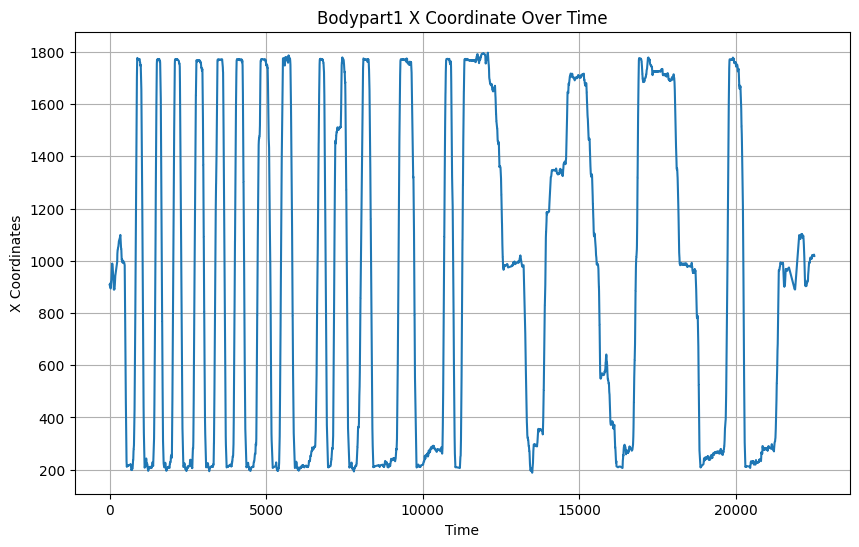

In [38]:
# Plot x coordinates against timestamps
plt.figure(figsize=(10, 6))
plt.plot(bodypart2_x,markersize=2)
plt.title('Bodypart1 X Coordinate Over Time')
plt.xlabel('Time')
plt.ylabel('X Coordinates')
plt.grid(True)
plt.show()

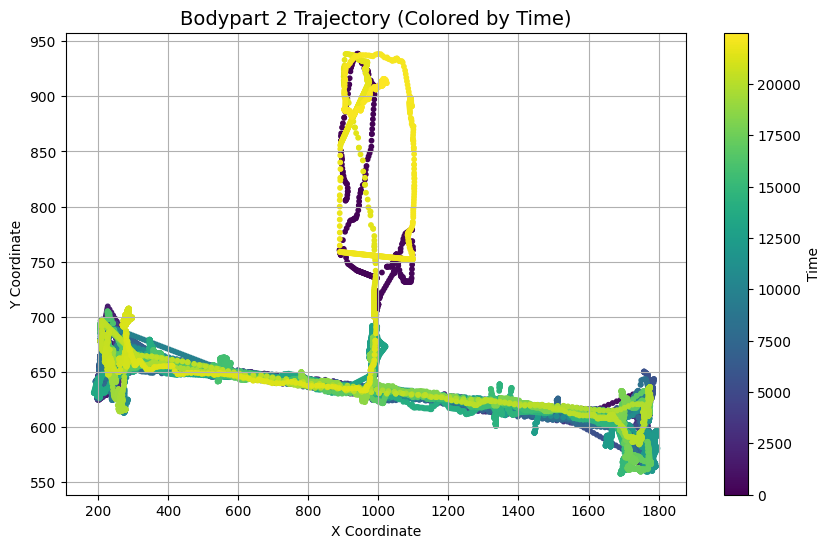

In [39]:
# Color-coding by time
plt.figure(figsize=(10, 6))
scatter = plt.scatter(bodypart2_x, bodypart2_y, c=timestamps, cmap='viridis', s=10)
plt.colorbar(scatter, label='Time')
plt.title("Bodypart 2 Trajectory (Colored by Time)", fontsize=14)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

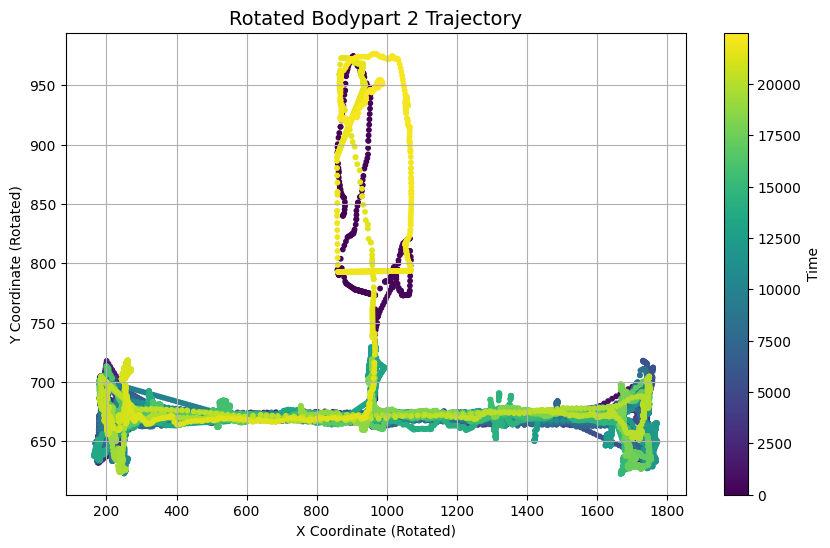

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Stack x and y coordinates into a 2D array
coordinates = np.vstack((bodypart2_x, bodypart2_y)).T

# Perform PCA to find the main trajectory axis
pca = PCA(n_components=2)
pca.fit(coordinates)

# Extract the principal components
principal_axis = pca.components_[0]

# Calculate the rotation angle to align with the x-axis
angle = np.arctan2(principal_axis[1], principal_axis[0])

# Build the 2D rotation matrix
rotation_matrix = np.array([
    [np.cos(-angle), -np.sin(-angle)],
    [np.sin(-angle), np.cos(-angle)]
])

# Rotate the coordinates
rotated_coordinates = coordinates @ rotation_matrix.T

# Extract the rotated x and y
rotated_x, rotated_y = rotated_coordinates[:, 0], rotated_coordinates[:, 1]

# Plot the rotated trajectory
plt.figure(figsize=(10, 6))
plt.scatter(rotated_x, rotated_y, c=timestamps, cmap='viridis', s=10)
plt.colorbar(label='Time')
plt.title("Rotated Bodypart 2 Trajectory", fontsize=14)
plt.xlabel("X Coordinate (Rotated)")
plt.ylabel("Y Coordinate (Rotated)")
plt.grid(True)
plt.show()


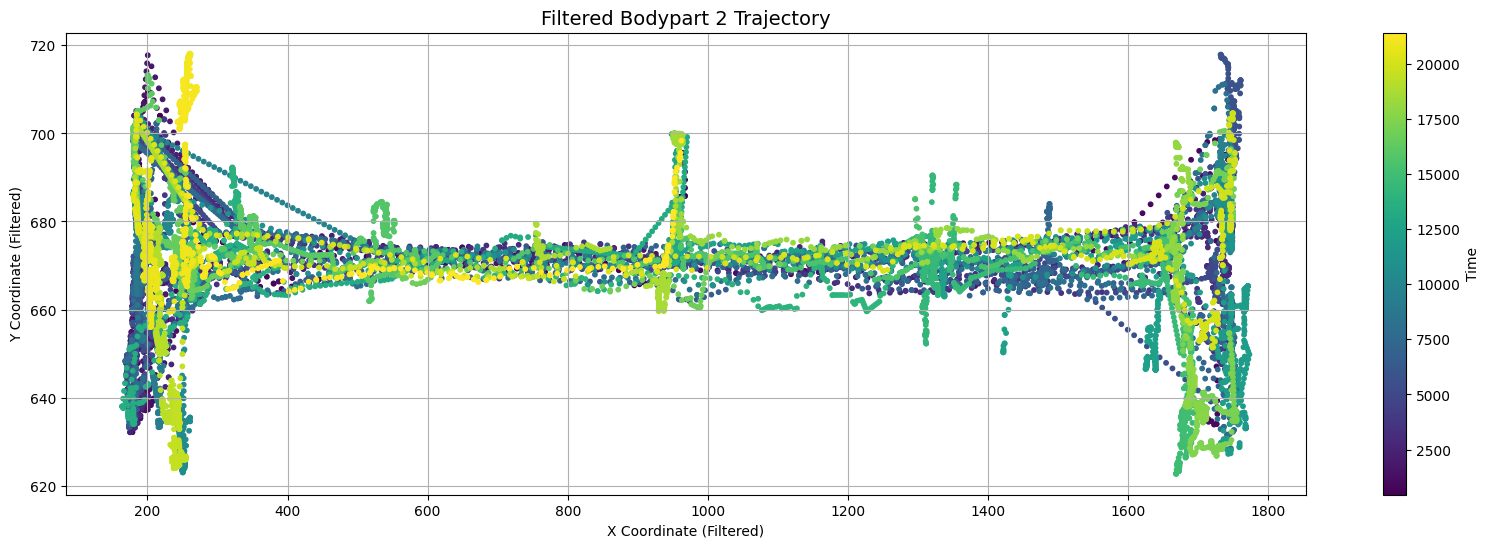

In [41]:
# Create a mask for the points to remove
mask = ~((rotated_x >= 800) & (rotated_x <= 1200) & (rotated_y > 700))

# Apply the mask to filter out the unwanted points
filtered_x = rotated_x[mask]
filtered_y = rotated_y[mask]
filtered_timestamps = timestamps[mask]

# Plot the filtered trajectory
plt.figure(figsize=(20, 6))
plt.scatter(filtered_x, filtered_y, c=filtered_timestamps, cmap='viridis', s=10)
plt.colorbar(label='Time')
plt.title("Filtered Bodypart 2 Trajectory", fontsize=14)
plt.xlabel("X Coordinate (Filtered)")
plt.ylabel("Y Coordinate (Filtered)")
plt.grid(True)
plt.show()


# Place Cells

In [69]:
# Define grid size
grid_size = 50  # pixels per bin

# Compute spatial bins
x_bins = np.arange(filtered_x.min(), filtered_x.max(), grid_size)
y_bins = np.arange(filtered_y.min(), filtered_y.max(), grid_size)

# Assign coordinates to bins
x_indices = np.digitize(filtered_x, x_bins) - 1
y_indices = np.digitize(filtered_y, y_bins) - 1


In [98]:
# Load the .npy file
session_dir = "/home/toor/Desktop/testSessions/20240625/"
file_path = session_dir+"F_dff_good.npy" 

# traces is neurons by time
traces = np.load(file_path).T
n_time, n_neurons = traces.shape
print(f"{n_neurons} neurons by {n_time} timepoints")

549 neurons by 22500 timepoints


In [106]:
# Neural activity data 
# Initialize spatial firing maps for each neuron
n_neurons = traces.shape[1]
firing_maps = np.zeros((len(x_bins), len(y_bins), n_neurons))

# Count time spent in each bin
occupancy = np.zeros((len(x_bins), len(y_bins)))

In [107]:
print(f"Neural activity shape: {traces.shape}")
print(f"Number of neurons (n_neurons): {n_neurons}")


Neural activity shape: (22500, 549)
Number of neurons (n_neurons): 549


In [108]:
print(f"x_indices range: {x_indices.min()} to {x_indices.max()}")
print(f"y_indices range: {y_indices.min()} to {y_indices.max()}")
print(f"firing_maps shape: {firing_maps.shape}")
print(f"traces shape: {traces.shape}")


x_indices range: 0 to 32
y_indices range: 0 to 1
firing_maps shape: (33, 2, 549)
traces shape: (22500, 549)


In [ ]:
# Populate the firing map
for i, (x_idx, y_idx) in enumerate(zip(x_indices, y_indices)):
    if 0 <= x_idx < len(x_bins) - 1 and 0 <= y_idx < len(y_bins) - 1:
        occupancy[x_idx, y_idx] += 1
        for neuron in range(n_neurons):
            firing_maps[x_idx, y_idx, neuron] += traces[i, neuron]


# Normalize firing maps by occupancy
for neuron in range(n_neurons):
    firing_maps[:, :, neuron] /= occupancy + 1e-6  # Avoid division by zero

In [111]:
def spatial_information(firing_map, occupancy):
    p = occupancy / occupancy.sum()
    mean_rate = firing_map.sum() / occupancy.sum()
    info = np.nansum(p * (firing_map / mean_rate) * np.log2(firing_map / mean_rate + 1e-6))
    return info

# Compute spatial information for each neuron
spatial_info = np.array([
    spatial_information(firing_maps[:, :, neuron], occupancy) for neuron in range(n_neurons)
])


In [ ]:
# Shuffle timestamps to generate null distribution
n_shuffles = 10
null_distributions = np.zeros((n_neurons, n_shuffles))

for shuffle in range(n_shuffles):
    shuffled_indices = np.random.permutation(len(filtered_timestamps))
    shuffled_activity = traces[shuffled_indices]
    for neuron in range(n_neurons):
        shuffled_firing_map = np.zeros((len(x_bins), len(y_bins)))
        for i, (x_idx, y_idx) in enumerate(zip(x_indices, y_indices)):
            if 0 <= x_idx < len(x_bins) and 0 <= y_idx < len(y_bins):
                shuffled_firing_map[x_idx, y_idx] += shuffled_activity[i, neuron]
        null_distributions[neuron, shuffle] = spatial_information(
            shuffled_firing_map, occupancy
        )


Identified 5 significant place cells.


In [ ]:
# Compare observed spatial info to null distribution
p_values = np.array([
    (null_distributions[neuron] >= spatial_info[neuron]).mean()
    for neuron in range(n_neurons)
])

# Identify significant place cells
significant_place_cells = np.where(p_values < 0.05)[0]
print(f"Identified {len(significant_place_cells)} significant place cells.")

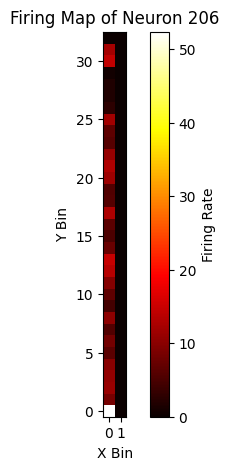

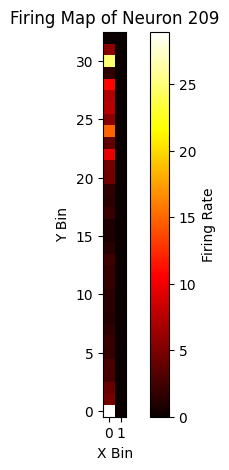

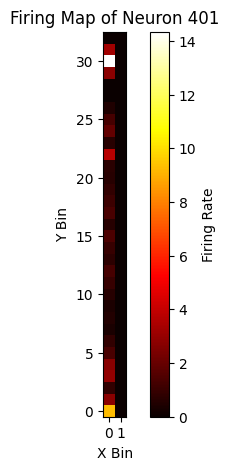

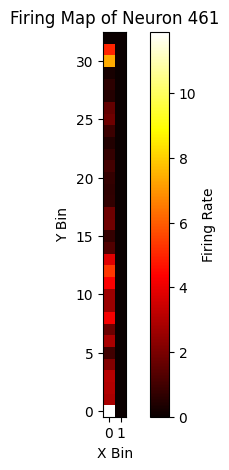

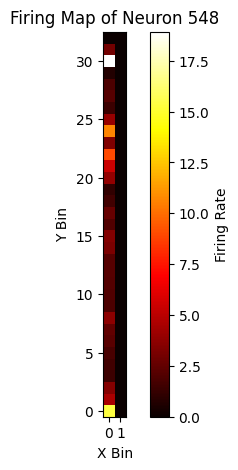

In [114]:
# Visualize firing maps of significant place cells
for neuron in significant_place_cells[:5]:  # Display first 5 place cells
    plt.figure(figsize=(6, 5))
    plt.imshow(firing_maps[:, :, neuron], origin='lower', cmap='hot')
    plt.title(f"Firing Map of Neuron {neuron}")
    plt.colorbar(label='Firing Rate')
    plt.xlabel("X Bin")
    plt.ylabel("Y Bin")
    plt.show()


### Run Rastermap

Let's sort the single neurons with Rastermap, skipping clustering and upsampling:

In [42]:
model = Rastermap(n_clusters=2, # None turns off clustering and sorts single neurons
                  n_PCs=64, # use fewer PCs than neurons
                  locality=0.1, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(traces)
y = model.embedding # neurons x 1
isort = model.isort

2024-11-22 18:41:36,364 [INFO] normalizing data across axis=1
2024-11-22 18:41:36,467 [INFO] projecting out mean along axis=0
2024-11-22 18:41:36,613 [INFO] data normalized, 0.25sec
2024-11-22 18:41:36,614 [INFO] sorting activity: 549 valid samples by 22500 timepoints
2024-11-22 18:41:39,555 [INFO] n_PCs = 64 computed, 3.19sec
2024-11-22 18:41:39,670 [INFO] 2 clusters computed, time 3.31sec
2024-11-22 18:41:39,716 [INFO] clusters sorted, time 3.35sec
2024-11-22 18:41:39,913 [INFO] rastermap complete, time 3.55sec


compute tuning curves along linear corridor

In [43]:
n_pos = 15
bins = np.arange(-1, 1+1./n_pos, 1./n_pos)
ibin = np.digitize(loc_signed, bins) - 1
n_bins = ibin.max()
inan = np.isnan(loc_signed)
ibin[inan] = -1
tcurves = np.zeros((traces.shape[0], n_bins))
for b in range(n_bins):
    tcurves[:, b] = traces[:, ibin==b].mean(axis=1)
tcurves -= tcurves.mean(axis=1, keepdims=True)

NameError: name 'loc_signed' is not defined

### Visualization

Use the Rastermap sorting to visualize the neural activity and tuning curves:

Text(0, 0.5, 'superneurons')

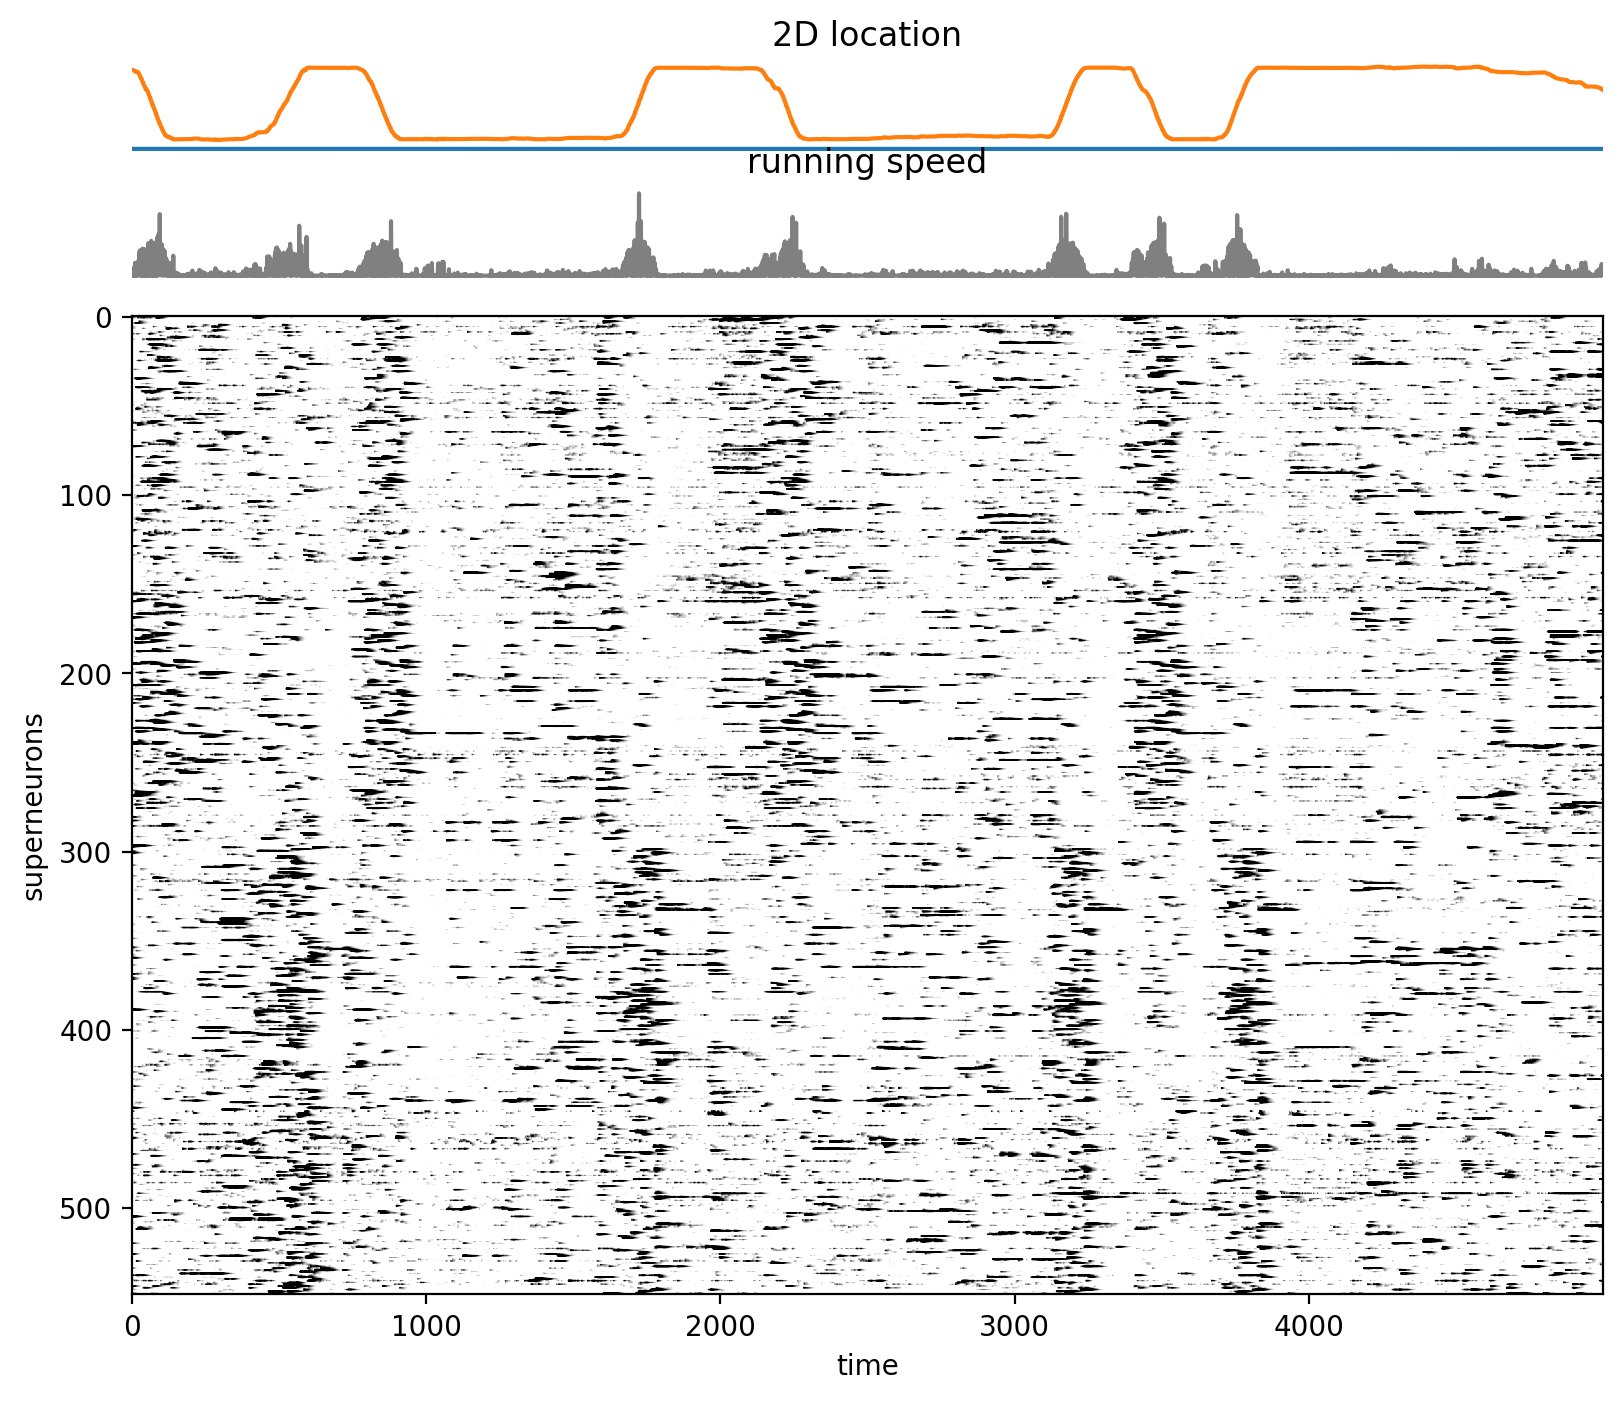

In [ ]:
# timepoints to visualize
xmin = 7500
xmax = xmin + 5000

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,8), dpi=200)
grid = plt.GridSpec(10, 24, figure=fig, wspace = 0.1, hspace = 0.4)

# plot location
ax = plt.subplot(grid[0, :-5])
ax.plot(loc2d[xmin:xmax])#, color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("2D location")

# plot running speed
ax = plt.subplot(grid[1, :-5])
ax.plot(speed[xmin:xmax], color=0.5*np.ones(3))
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed")

# plot sorted neural activity
ax = plt.subplot(grid[2:, :-5])
ax.imshow(traces[isort, xmin:xmax], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")



ValueError: x and y must have same first dimension, but have shapes (15,) and (6,)

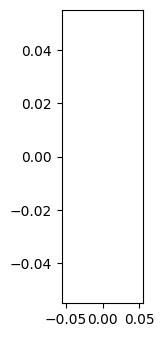

In [ ]:

# plot single-neuron tuning curves
ax = plt.subplot(grid[2:, -4:])
x = np.arange(0, n_pos)
dy = 2
xpad = n_pos/10
nn = traces.shape[0]
for t in range(len(tcurves)):
    ax.plot(x, tcurves[isort[t], :n_pos]*dy - dy/2 + nn - t,
            color="k", lw=0.5)
    ax.plot(x+n_pos+xpad, tcurves[isort[t], n_pos:]*dy - dy/2 + nn - t,
            color="k", lw=0.5)
for j in range(2):
    xstr = "position\n(left run)" if j==0 else "position\n(right run)"
    ax.text(n_pos/2 + j*(n_pos+xpad), -14, xstr, ha="center")
    ax.text(j*(n_pos+xpad), -3, "0")
    ax.text(n_pos + j*(n_pos+xpad), -3, "1.6", ha="right")
ax.set_ylim([0, nn])
ax.axis("off")

### Settings

You can see all the rastermap settings with `Rastermap?`

In [ ]:
Rastermap?

Init signature:
Rastermap(
    n_clusters=100,
    n_PCs=200,
    time_lag_window=0.0,
    locality=0.0,
    grid_upsample=10,
    time_bin=0,
    normalize=True,
    mean_time=True,
    n_splits=0,
    run_scaled_kmeans=True,
    verbose=True,
    verbose_sorting=False,
    keep_norm_X=True,
    bin_size=0,
    symmetric=False,
    random_state=0,
    sticky=True,
    nc_splits=None,
    smoothness=1,
)
Docstring:     
Rastermap embedding algorithm
Rastermap takes the n_PCs (200 default) of the data, and embeds them into
n_clusters clusters. It then sorts the clusters and upsamples to a grid with 
grid_upsample * n_clusters nodes. Each data sample is assigned to a node. 
The assignment of the samples to nodes is attribute `embedding`, and the sorting 
of the nodes is `isort`.

Parameters in order of importance

Parameters
-----------
n_clusters : int, optional (default: 100)
    number of clusters created from data before upsampling and creating embedding
    (any number above 150 wil

### Outputs

All the attributes assigned to the Rastermap `model` are listed with `Rastermap.fit?`

In [ ]:
Rastermap.fit?